# EE4675 Object Classification with Radar Project

Object classification project for the TU Delft course EE4675 Object classification with radar

Written by:
- Adnane Acudad studentnumber
- Peter de Bruin studentnumber
- Joost Jaspers 5372925

### Imports and initializations:

In [21]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os

# Define the relative path to the dataset file
relative_path = 'datasets/1 December 2017 Dataset/1P36A01R01.dat'

# Get absolute full path based on current working directory (i.e., location of notebook)
fullpath = os.path.join(os.getcwd(), relative_path)

# Check if the file exists
if not os.path.exists(fullpath):
    raise FileNotFoundError(f"Could not find file at: {fullpath}")

### Data Reading part

In [22]:
# Read the data from the file as text, replace 'i' with 'j', and convert to complex
with open(fullpath, 'r') as f:
    lines = f.readlines()

# Convert header (first 4 lines) to float
header = [float(lines[i].strip()) for i in range(4)]

# Convert the rest to complex numbers
data_strs = [line.strip().replace('i', 'j') for line in lines[4:]]
data_complex = np.array([complex(s) for s in data_strs])

# Combine header and data for compatibility with the rest of the code
radarData = np.array(header + list(data_complex))

# Extract parameters
fc = radarData[0]  # Center frequency in Hz
Tsweep = radarData[1] / 1000  # Sweep time in seconds (converted from ms)
NTS = int(radarData[2])  # Number of time samples per sweep
Bw = radarData[3]  # Bandwidth in Hz
Data = radarData[4:]  # Raw radar data

# Calculate sampling parameters
fs = NTS / Tsweep  # Sampling frequency
nc = int(len(Data) / NTS)  # Number of chirps

C:\Users\Joost\AppData\Local\Temp\ipykernel_12216\2055694429.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  NTS = int(radarData[2])  # Number of time samples per sweep


### Reshape data into chirps and plot range-time

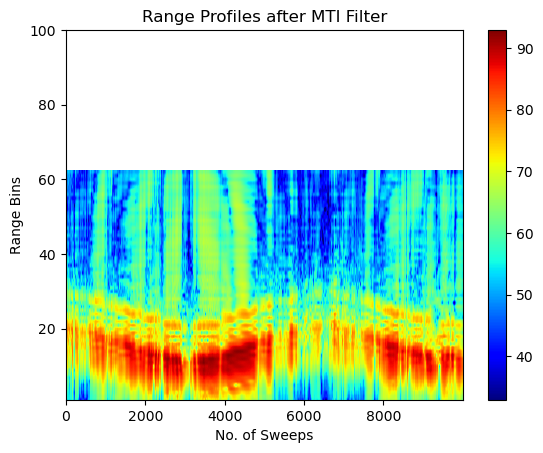

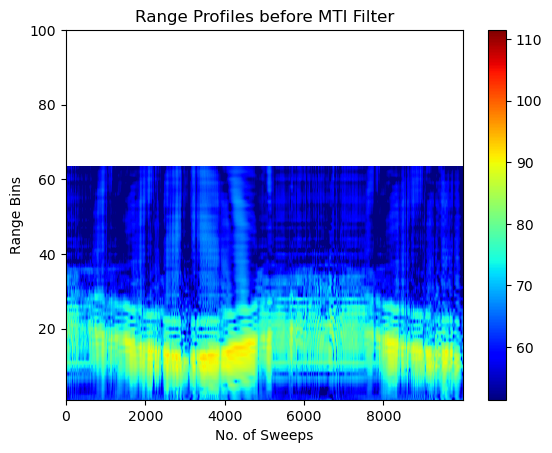

In [23]:
# Reshape data into [NTS, nc] array
Data_time = Data.reshape((NTS, nc), order='F')  # Fortran order to match MATLAB's column-major

# Apply a rectangular window
win = np.ones((NTS, nc))

# Compute FFT and shift zero-frequency component to center
tmp = np.fft.fftshift(np.fft.fft(Data_time * win, axis=0), axes=0)
Data_range = tmp[NTS//2:, :]  # Take positive frequency components

# Number of sweeps to process (assuming ns = nc)
ns = nc

# Design a 4th-order high-pass Butterworth filter
b, a = signal.butter(4, 0.0075, 'high')

# Apply filter to each range bin across chirps
Data_range_MTI = np.zeros_like(Data_range, dtype=complex)
for k in range(Data_range.shape[0]):
    Data_range_MTI[k, :] = signal.lfilter(b, a, Data_range[k, :])

# Remove the first range bin
Data_range_MTI = Data_range_MTI[1:, :]

# Plot Range-Time Intensity
plt.figure()
im = plt.imshow(20 * np.log10(np.abs(Data_range_MTI)), aspect='auto', origin='lower', cmap='jet')
plt.xlabel('No. of Sweeps')
plt.ylabel('Range Bins')
plt.title('Range Profiles after MTI Filter')
clim = im.get_clim()
plt.clim(clim[1] - 60, clim[1])  # Set color limits
plt.ylim(1, 100)  # Limit range bins displayed
plt.colorbar()
plt.savefig('range_time_plot.png')

plt.figure()
im = plt.imshow(20 * np.log10(np.abs(Data_range)), aspect='auto', origin='lower', cmap='jet')
plt.xlabel('No. of Sweeps')
plt.ylabel('Range Bins')
plt.title('Range Profiles before MTI Filter')
clim = im.get_clim()
plt.clim(clim[1] - 60, clim[1])  # Set color limits
plt.ylim(1, 100)  # Limit range bins displayed
plt.colorbar()
plt.savefig('range_time_plot_before_mti.png')

### Spectrogram processing for 2nd FFT to get Doppler

C:\Users\Joost\AppData\Local\Temp\ipykernel_12216\1619459260.py:14: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Sxx = signal.spectrogram(Data_range_MTI[RBin, :], fs=PRF, window='hann',
c:\Users\Joost\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1947: ComplexWarning: Casting complex values to real discards the imaginary part
  nperseg - noverlap)/float(fs)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transf

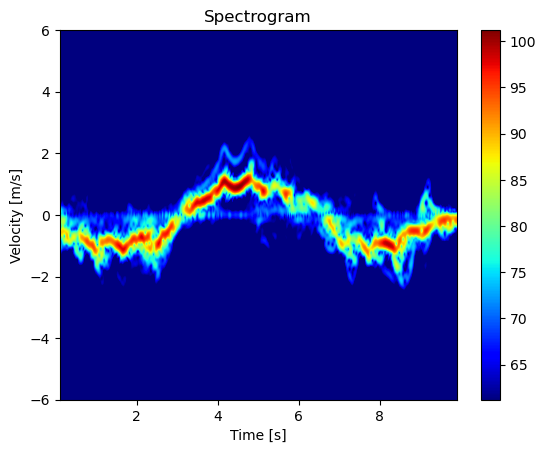

In [24]:

# Spectrogram parameters for Doppler processing
bin_indl = 10 - 1  # Adjust for 0-based indexing
bin_indu = 30 - 1  # Adjust for 0-based indexing
PRF = 1 / Tsweep  # Pulse repetition frequency
TimeWindowLength = 200
OverlapFactor = 0.95
OverlapLength = int(np.round(TimeWindowLength * OverlapFactor))
Pad_Factor = 4
FFTPoints = Pad_Factor * TimeWindowLength

# Compute spectrogram for selected range bins and sum magnitudes
Data_spec_MTI2 = None
for RBin in range(bin_indl, bin_indu + 1):
    f, t, Sxx = signal.spectrogram(Data_range_MTI[RBin, :], fs=PRF, window='hann',
                                   nperseg=TimeWindowLength, noverlap=OverlapLength,
                                   nfft=FFTPoints, mode='complex')
    Sxx_shifted = np.fft.fftshift(Sxx, axes=0)
    if Data_spec_MTI2 is None:
        Data_spec_MTI2 = np.abs(Sxx_shifted)
    else:
        Data_spec_MTI2 += np.abs(Sxx_shifted)

# Compute Doppler and velocity axes
DopplerAxis = np.fft.fftshift(np.fft.fftfreq(FFTPoints, d=1 / PRF))
velocity_axis = DopplerAxis * 3e8 / (2 * fc)  # Convert Doppler frequency to velocity

# Plot Spectrogram
plt.figure()
im = plt.imshow(20 * np.log10(Data_spec_MTI2), aspect='auto', origin='lower',
                extent=[t[0], t[-1], velocity_axis[0], velocity_axis[-1]], cmap='jet')
plt.ylim(-6, 6)  # Limit velocity axis
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Spectrogram')
clim = im.get_clim()
plt.clim(clim[1] - 40, clim[1])  # Set color limits
plt.colorbar()
plt.savefig('spectrogram_plot.png')

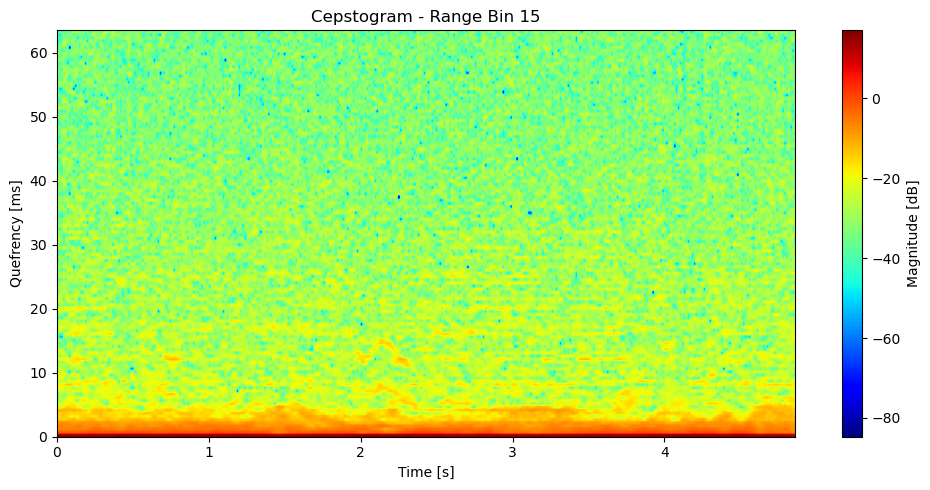

In [28]:
# === Parameters ===
selected_bin = 15  # adjust as needed
window_length = 256
overlap = int(0.9 * window_length)
step = window_length - overlap
fs = 2000  # Example sampling rate in Hz — replace with your real fs

# === Input signal from selected range bin ===
data_signal = Data_range_MTI[selected_bin, :]  # if 2D
data_signal = data_signal.astype(np.complex64)  # ensure it's complex if needed

# === Cepstrogram computation ===
num_frames = int((len(data_signal) - window_length) / step) + 1
cepstrogram = []

for k in range(num_frames):
    idx_start = k * step
    idx_end = idx_start + window_length
    frame = data_signal[idx_start:idx_end] * signal.windows.hann(window_length)
    
    spectrum = np.fft.fft(frame)
    log_mag = np.log(np.abs(spectrum) + np.finfo(float).eps)
    cepstrum = np.abs(np.fft.ifft(log_mag))
    
    cepstrogram.append(cepstrum[:window_length // 2])  # keep first half

cepstrogram = np.array(cepstrogram).T  # shape: [quefrency × time]

# === Axes ===
quefrency = np.arange(window_length // 2) / fs  # in seconds
time_axis = np.arange(num_frames) * step / fs   # in seconds

# === Plotting ===
plt.figure(figsize=(10, 5))
plt.imshow(20 * np.log10(cepstrogram + 1e-12), aspect='auto', origin='lower',
           extent=[time_axis[0], time_axis[-1], quefrency[0]*1e3, quefrency[-1]*1e3],
           cmap='jet')
plt.xlabel("Time [s]")
plt.ylabel("Quefrency [ms]")
plt.title(f"Cepstogram - Range Bin {selected_bin}")
plt.colorbar(label='Magnitude [dB]')
plt.tight_layout()
plt.show()